Predicting Korfball Results with Statistical Modelling
======
*Description*

[Rework of Predicting Football Results with Statistical Modelling by David Sheehan](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/)

Introduction

## Poisson Distribution

The model is founded on the number of goals scored/conceded by each team. Teams that have been higher scorers in the past have a greater likelihood of scoring goals in the future. We'll import all match results from the concluded National League (2018/19) Season.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson, skellam
%matplotlib inline

DATA_DIR = '../data/'

nl_1819 = pd.read_csv(DATA_DIR + 'all_data.csv', index_col=0)
nl_1819 = nl_1819.loc[nl_1819.Season == '2018/19'].copy().reset_index(drop=True)

In [2]:
nl_1819 = nl_1819[['Home Team', 'Away Team', 'Home Score', 'Away Score']].copy()

In [3]:
nl_1819.head()

,Home Team,Away Team,Home Score,Away Score
0,Bristol Thunder 1,Nomads 1,20.0,21.0
1,Kingfisher 1,KV 1,23.0,17.0
2,Trojans 1,Tornadoes 1,21.0,14.0
3,Cambridge Tigers 1,Birmingham City 1,13.0,15.0
4,Bec 1,Norwich Knights 1,16.0,22.0


In [4]:
nl_1819

,Home Team,Away Team,Home Score,Away Score
0,Bristol Thunder 1,Nomads 1,20.0,21.0
1,Kingfisher 1,KV 1,23.0,17.0
2,Trojans 1,Tornadoes 1,21.0,14.0
3,Cambridge Tigers 1,Birmingham City 1,13.0,15.0
4,Bec 1,Norwich Knights 1,16.0,22.0
...,...,...,...,...
85,Birmingham City 1,Kingfisher 1,14.0,23.0
86,Nomads 1,Tornadoes 1,29.0,35.0
87,Norwich Knights 1,Bec 1,16.0,20.0
88,Trojans 1,Kingfisher 1,31.0,11.0


We imported a csv as a pandas dataframe, which contains various information for each of the 90 NKL games in the 2018-19 England Korfball National League season. We restricted the dataframe columns in which we're interested (specifically, team names and number of goals scored by each team). 

Our task is to model the final round of fixtures in the season, so we must remove the last 5 rows (each gameweek consists of 5 matches).

In [5]:
nl_1819 = nl_1819[: -10]

In [6]:
nl_1819.mean()

Home Score    21.8500
Away Score    22.3125
dtype: float64

You'll notice that, on average, the home team scores fewer goals than the away team. This is against the so called 'home (field) advantage' (discussed [here](https://jogall.github.io/2017-05-12-home-away-pref/) and isn't specific to [korfball](http://bleacherreport.com/articles/1803416-is-home-field-advantage-as-important-in-baseball-as-other-major-sports). This is a convenient time to introduce the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution). It's a discrete probability distribution that describes the probability of the number of events within a specific time period (e.g. 60 mins) with a known average rate of occurence. A key assumption is that the number of events is independent of time. In our context, this means that goals don't become more/less likely by the number of goals already scored in the match. Instead, the number of goals is expressed purely as a function of an average rate of goals. If that was unclear, maybe this mathematical formulation will make it clearer:

$P(x) = \frac{e^{-\lambda}\lambda^{x}}{x!), \lambda > 0$

$\lambda$ represents the average rate (e.g. average number of goals, average number of letters you receive, etc.). So, we can treat the number of goals scored by the home and away team as two independent Poisson distributions. The plot below shows the proporttion of goals scored compared to the number of goals estimated by the corresponding Poisson distributions.

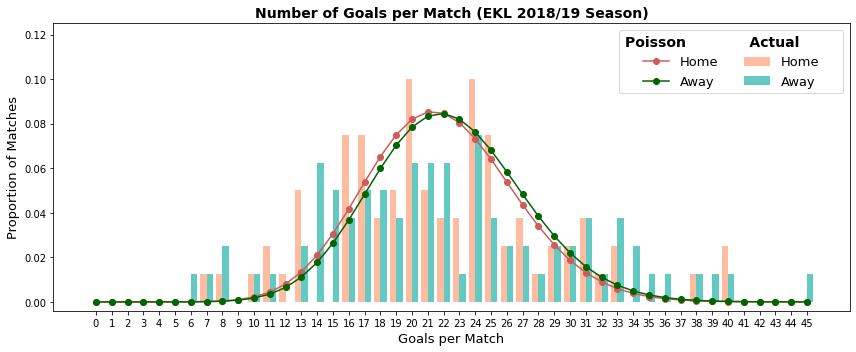

In [7]:
poisson_pred = np.column_stack([[poisson.pmf(i, nl_1819.mean()[j]) 
                                 for i in range(46)] 
                                 for j in range(2)])

plt.figure(figsize=(12,5))
# plot histogram of actual goals
plt.hist(nl_1819[['Home Score', 'Away Score']].values, range(47),
         alpha=0.7, label=['Home', 'Away'], density=True, color=['#FFA07A', '#20B2AA'])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1, 47)], poisson_pred[:,0],
                  linestyle='-', marker='o', label="Home", color='#CD5C5C',)
pois2, = plt.plot([i-0.5 for i in range(1, 47)], poisson_pred[:,1],
                  linestyle='-', marker='o', label="Away", color='#006400')

leg = plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title('Poisson             Actual        ', prop={'size': 14, 'weight': 'bold'})
plt.xticks([i-0.5 for i in range(1, 47)], [i for i in range(47)])
plt.xlabel("Goals per Match", size=13)
plt.ylabel("Proportion of Matches", size=13)
plt.title("Number of Goals per Match (EKL 2018/19 Season)", size=14, fontweight='bold')
plt.ylim([-0.004, 0.125])
plt.tight_layout()
plt.show()

We can use this statistical model to estimate the probability of specific events.

$$
\begin{align*}
P(\geq 30|\text{Home}) &= P(20|\text{Home}) + P(21|\text{Home})  +  ...\\
               &= 0.082 + 0.085 + ...\\
               &= 0.683   
\end{align*}
$$
The probability of a draw is simply the sum of the events where the two teams score the same amount of goals

$$
\begin{align*}
P(\text{Draw}) &= P(0|\text{Home}) \times P(0|\text{Away}) + P(1|\text{Home}) \times P(1|\text{Away}) + ...\\
    &= 0.000 \times 0.000 + 0.000 \times 0.000 + ... \\
    &= 0.06 
\end{align*}
$$

Note that we consider the number of goals scored by each team to be independent events (i.e. P(A n B) = P(A)P(B)). The difference of two Poisson distributions is actually called a [Skellam distribution](https://en.wikipedia.org/wiki/Skellam_distribution). So we can calculate the probability of a draw by inputting the mean goal values into this distribution.

In [8]:
# probability of draw between home and away team
skellam.pmf(0.0, nl_1819.mean()[0], nl_1819.mean()[1])

0.06006022024029264

In [9]:
# probability of home team winning by one goal
skellam.pmf(1, nl_1819.mean()[0], nl_1819.mean()[1])

0.058757644996049685

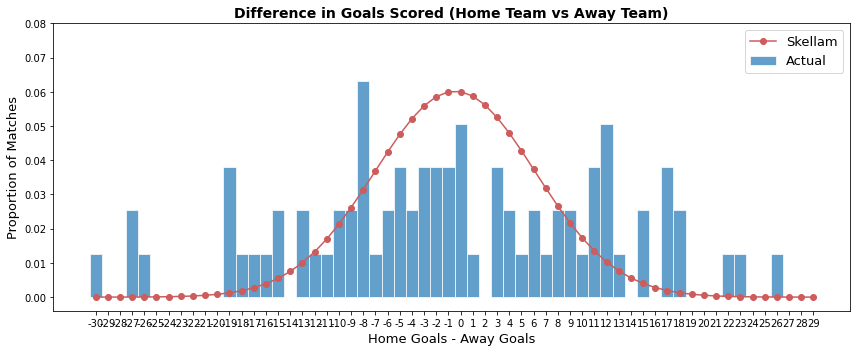

In [10]:
skellam_pred = [skellam.pmf(i, nl_1819.mean()[0], nl_1819.mean()[1]) for i in range (-30, 30)]

plt.figure(figsize=(12,5))
plt.hist(nl_1819[['Home Score']].values - nl_1819[['Away Score']].values, range(-30,30), 
         alpha=0.7, label='Actual', density=True, edgecolor='white')
plt.plot([i+0.5 for i in range(-30, 30)], skellam_pred,
         linestyle='-', marker='o', label='Skellam', color='#CD5C5C')
plt.legend(loc='upper right', fontsize=13)
plt.xticks([i+0.5 for i in range(-30,30)], [i for i in range(-30, 30)])
plt.xlabel("Home Goals - Away Goals", size=13)
plt.ylabel("Proportion of Matches", size=13)
plt.title("Difference in Goals Scored (Home Team vs Away Team)", size=14, fontweight='bold')
plt.ylim([-0.004, 0.08])
plt.tight_layout()
plt.show()

So, hopefully you can see how we can adapt this approach to model specific matches. We just need to know the average number of goals scored by each team and feed this data into a Poisson model. Let's have a look at the distribution of goals scored by Trojans and Birmingham City (teams who finished 1st and last, respectively).

In [11]:

tro_home = nl_1819[nl_1819['Home Team']=='Trojans 1'][['Home Score']].apply(
    pd.value_counts, normalize=True)
tro_home_pois = [poisson.pmf(i, np.sum(np.multiply(tro_home.values.T, 
                                                    tro_home.index.T),axis=1)[0]) 
                  for i in range(45)]

brum_home = nl_1819[nl_1819['Home Team']=='Birmingham City 1'][['Home Score']].apply(
    pd.value_counts, normalize=True)

brum_home_pois = [poisson.pmf(i, np.sum(np.multiply(brum_home.values.T,
                                                     brum_home.index.T),axis=1)[0])
                   for i in range(45)]

tro_away = nl_1819[nl_1819['Away Team']=='Trojans 1'][['Away Score']].apply(
    pd.value_counts, normalize=True)
tro_away_pois = [poisson.pmf(i, np.sum(np.multiply(tro_away.values.T, 
                                                    tro_away.index.T),axis=1)[0]) 
                  for i in range(45)]

brum_away = nl_1819[nl_1819['Away Team']=='Birmingham City 1'][['Away Score']].apply(
    pd.value_counts, normalize=True)

brum_away_pois = [poisson.pmf(i, np.sum(np.multiply(brum_away.values.T,
                                                     brum_away.index.T),axis=1)[0])
                   for i in range(45)]



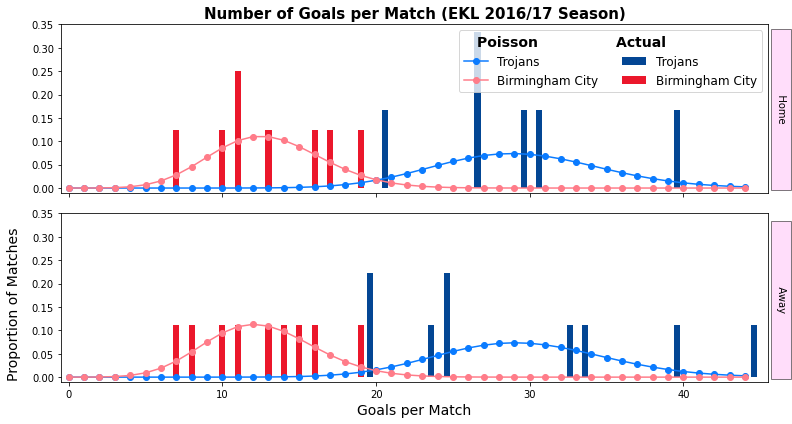

In [12]:
fig , (ax1, ax2) = plt.subplots(2, 1, figsize=(11,6))


ax1.bar(tro_home.index-0.4,tro_home['Home Score'].values,width=0.4,color='#034694',label='Trojans')
ax1.bar(brum_home.index,brum_home['Home Score'].values,width=0.4,color='#EB172B',label='Birmingham City')
pois1, = ax1.plot([i for i in range(45)], tro_home_pois,
                  linestyle='-', marker='o', label='Trojans', color='#0a7bff')
pois1, = ax1.plot([i for i in range(45)], brum_home_pois, 
                  linestyle='-', marker='o', label='Birmingham City', color='#ff7c89')
leg=ax1.legend(loc='upper right', fontsize=12, ncol=2)
leg.set_title('Poisson                Actual                ',prop={'size':'14', 'weight':'bold'})
ax1.set_xlim([-0.5, 45.5])
ax1.set_ylim([-0.01, 0.35])
ax1.set_xticklabels([])
# mimicing the facet plots in ggplot2 with a bit of a hack
ax1.text(46, 0.01, '                   Home                    ', rotation=-90,
        bbox={'facecolor': '#ffbcf6', 'alpha':0.5, 'pad':5})
ax2.text(46, 0.01, '                   Away                    ', rotation=-90,
        bbox={'facecolor': '#ffbcf6', 'alpha':0.5, 'pad':5})
ax2.bar(tro_away.index-0.4,tro_away['Away Score'].values,width=0.4,color='#034694',label='Bec')
ax2.bar(brum_away.index,brum_away['Away Score'].values,width=0.4,color='#EB172B',label='Birmingham City')
pois1, = ax2.plot([i for i in range(45)], tro_away_pois,
                  linestyle='-', marker='o',label="Trojans", color = "#0a7bff")
pois1, = ax2.plot([i for i in range(45)], brum_away_pois,
                  linestyle='-', marker='o',label="Birmingham City", color = "#ff7c89")
ax2.set_xlim([-0.5,45.5])
ax2.set_ylim([-0.01,0.35])
ax1.set_title("Number of Goals per Match (EKL 2016/17 Season)",size=15,fontweight='bold')
ax2.set_xlabel("Goals per Match",size=14)
ax2.text(-4, 0, 'Proportion of Matches', rotation=90, size=14)
plt.tight_layout()
plt.show()

## Building A Model
You should now be convinved that the number of goals scored by each team can be approximated by a Poisson distribution. Due to a relatively sample size ( each team plays at most 9 home/away games), the accuracy of this approximation can vary significantly (especially earlier in the season when teams have played fewer games). Similar to before, we could now calculate the probability of various events in this Trojans - Birmingham City match. But rather tan treat each match separately, we'll build a more general Poisson regression model ([what is that?](https://en.wikipedia.org/wiki/Poisson_regression)).

In [13]:
# importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

goal_model_data = pd.concat(
    [nl_1819[['Home Team', 'Away Team', 'Home Score']].assign(home=1).rename(
        columns={'Home Team': 'team', 'Away Team': 'opponent', 'Home Score': 'goals'}),
    nl_1819[['Away Team', 'Home Team', 'Away Score']].assign(home=0).rename(
        columns={'Away Team': 'team', 'Home Team': 'opponent', 'Away Score': 'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data,
                       family=sm.families.Poisson()).fit()

poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  160
Model:                            GLM   Df Residuals:                      140
Model Family:                 Poisson   Df Model:                           19
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -451.20
Date:                Fri, 07 Aug 2020   Deviance:                       121.85
Time:                        14:21:33   Pearson chi2:                     120.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          2.9782      0.083     35.977      0.000       2.816       3.140
team[T.Birmingham City 1]         -0.6663      0.084     -7.914      0.000      -0.831      -0.501
team[T.Bristol Thunder 1]         -0.3956      0.078     -5.057      0.000      -0.549      -0.242
team[T.Cambridge Tigers 1]        -0.2381      0.078     -3.063      0.002      -0.390      -0.086
team[T.KV 1]                      -0.2246      0.076     -2.949      0.003      -0.374      -0.075
team[T.Kingfisher 1]              -0.1268      0.073     -1.742      0.081      -0.270       0.016
team[T.Nomads 1]                  -0.1438      0.072     -1.986      0.047      -0.286      -0.002
team[T.Norwich Knights 1]          0.0825      0.068      1.211      0.226      -0.051       0.216
team[T.Tornadoes 1]                0.0738      0.070      1.059      0.290      -0.063       0.210
team[T.Trojans 1]                  0.1269      0.069      1.849      0.064      -0.008       0.261
opponent[T.Birmingham City 1]      0.3001      0.080      3.751      0.000       0.143       0.457
opponent[T.Bristol Thunder 1]      0.4743      0.078      6.096      0.000       0.322       0.627
opponent[T.Cambridge Tigers 1]     0.3871      0.082      4.749      0.000       0.227       0.547
opponent[T.KV 1]                   0.3451      0.082      4.193      0.000       0.184       0.506
opponent[T.Kingfisher 1]           0.2868      0.082      3.507      0.000       0.127       0.447
opponent[T.Nomads 1]               0.4023      0.080      5.055      0.000       0.246       0.558
opponent[T.Norwich Knights 1]      0.0297      0.087      0.341      0.733      -0.141       0.200
opponent[T.Tornadoes 1]            0.1935      0.084      2.298      0.022       0.028       0.359
opponent[T.Trojans 1]              0.0230      0.089      0.258      0.796      -0.152       0.198
home                              -0.0338      0.034     -0.995      0.320      -0.100       0.033
==================================================================================================
"""

If you're curious about the `smf.glm(...)` part, you can find more information [here](http://www.statsmodels.org/stable/examples/notebooks/generated/glm_formula.html). I'm more interested in the values presented in the `coef` column in the model summary table, which are analogous to the slopes in linear regression. Similar to [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression), we take the [exponent of the parameter values](http://www.lisa.stat.vt.edu/sites/default/files/Poisson.and_.Logistic.Regression.pdf). A positive value implies more goals ($e^{x} > 1,  \forall x > 0$), while values closer to zero represent more neutral effects ($e^{0} = 1$). Towards the bottom of the table you might notice that `home` has a `coef` of -0.0338. This captures the fact that home teams generally score fewer goals than the away team (specifically, $\frac{1}{e^{-0.0338}}=1.03$ times more likely). But not all teams are created equal. Trojans has a `coef` of 0.1269, while the corresponding value for Birmingham City is -0.6663 (sort of saying Trojans (Birmingham City) are better (much worse!) scorers than average). Finally, the `opponent*` values penalize/reward teams based on the quality of the opposition. This reflects the defensive strength of each team (Trojans: 0.0230; Birmingham City: 0.3001). In other words, you're less likely to score against Trojans. Hopefully, that makes both statistical and intuitive sense.

Let's start making somre predictions for the upcoming matches. We simply pass our teams into `poisson_model` and it'll return the expected average number of goals for that team (we need to run it twice- we calculate the expected average number of goals for each team separately). So let's see how many goals we expect Trojans and Birmingham City to score.

In [14]:
poisson_model.predict(pd.DataFrame(data={'team': 'Trojans 1', 'opponent': 'Birmingham City 1',
                                         'home': 1}, index=[1]))

1    29.120671
dtype: float64

In [15]:
poisson_model.predict(pd.DataFrame(data={'team': 'Birmingham City 1', 'opponent': 'Trojans 1',
                                         'home': 0}, index=[1]))

1    10.328497
dtype: float64

Just like before, we have two Poisson distributions. From this, we can calculate the probability of various events. I'll wrap this in a `simulate_match` function.

In [16]:
def simulate_match(korf_model, homeTeam, awayTeam, max_goals=45):
    home_goals_avg = korf_model.predict(pd.DataFrame(data={'team': homeTeam,
                                                           'opponent': awayTeam,
                                                           'home': 1},
                                                    index=[1])).values[0]
    away_goals_avg = korf_model.predict(pd.DataFrame(data={'team': awayTeam,
                                                           'opponent': homeTeam,
                                                           'home': 0},
                                                    index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(max_goals+1)] 
                 for team_avg in [home_goals_avg, away_goals_avg]]
    
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

simulate_match(poisson_model, 'Trojans 1', 'Birmingham City 1', max_goals=40)


array([[7.36960415e-18, 7.61169319e-17, 3.93086739e-16, ...,
        4.81209294e-24, 1.27440220e-24, 3.29066472e-25],
       [2.14607818e-16, 2.21657613e-15, 1.14469496e-14, ...,
        1.40131375e-22, 3.71114473e-23, 9.58263648e-24],
       [3.12476183e-15, 3.22740922e-14, 1.66671427e-13, ...,
        2.04035984e-21, 5.40355123e-22, 1.39526402e-22],
       ...,
       [6.14576651e-07, 6.34765289e-06, 3.27808558e-05, ...,
        4.01296990e-13, 1.06276785e-13, 2.74419855e-14],
       [4.58894473e-07, 4.73969004e-06, 2.44769364e-05, ...,
        2.99641990e-13, 7.93551614e-14, 2.04904880e-14],
       [3.34082875e-07, 3.45057386e-06, 1.78196203e-05, ...,
        2.18144395e-13, 5.77718887e-14, 1.49174190e-14]])

This matrix simply shows the probability of Trojans (rows of the matrix) and Birmingham City (matrix columns) scoring a specific number of goals. For example, along the diagonal, both teams score the same number of goals (e.g. P(0-0)=0.000). So, you can calculate the odds of draw by summing all the diagonal entries. Everything below the diagonal represents a Trojans victory (e.g. P(30-10)=0.009). If you prefer Over/Under markets, you can estimate P(Under 39.5 goals) by summing the entries where the sum of the column number and row number (both starting at zero) is less than 36 (i.e. the 820 values that form the upper left triangle). Luckily, we can use basic matrix manipulation functions to perform these calculations.

In [17]:
tro_brum = simulate_match(poisson_model, 'Trojans 1', 'Birmingham City 1', max_goals=40)
# Trojans win
np.sum(np.tril(tro_brum, -1))

0.9769209743247839

In [18]:
# draw
np.sum(np.diag(tro_brum))

0.0005802748010776943

In [19]:
# Birmingham City win
np.sum(np.triu(tro_brum, 1))

0.000759595615479841

Hmm, out models gives Birmingham City a 0.08% chance of winning. But is that right? To asses the accuracy of the predictions, we'll compare the probabilites returned by our model against the odds offered by the Betfair exchange.

## Something's Poissony

Should we bet the house on Trojans beating Kingfisher? Probably note (though they did win!). There's some non-statistical reasons to resist backing them. 

In a similar fashion, injuries/suspensions to key players, and other factors would render our model inaccurate. Never underestimate the importance of domain knowledge in statistical modelling/machine learning! We could also think of improvements to the model that would [incorporate time when considering previous matches](http://opisthokonta.net/?p=890) (i.e. more recent matches should be weighted more strongly).

Statistically speaking, is a Poisson distribution even appropriate? Our model was founded on the belief that the number of goals can be accurately expressed as a Poisson distribution. If that assumption is misguided, then the model outputs will be unreliable. Given a Poisson distribution with mean $\lambda$ , then the number of events in half that time period follows a Poisson distribution with mean $\lambda/2$. In korfball terms, according to our Poisson model, there should be an equal number of goals in the first and second halves. Unfortunately, that doesn't appear to hold true.


## Summary 
We built a simple Poisson model to predict the results of the English National Korfball League matches. Despite its inherent flaws, it recreates several features that would be a neccessity for any predictive korfball model (home advantage, varying offensive strengths and opposition quality). In conclusion, don't wager the rent money, but it's a good starting point for more sophisticated models. Thanks for reading!